# Tarea 4: Restauración de imagenes

### Felipe Montero Concha
### 201473611-8

## Instrucciones

* La tarea es individual.
* Las consultas sobre las tareas se deben realizar por medio de la plataforma Aula.
* La tarea debe ser realizada en `Jupyter Notebook` (`Python3`).
* Se evaluará la correcta utilización de librerias `NumPy`, `SciPy`, entre otras, así como la correcta utilizacion de algoritmos de forma vectorizada.
*  **El archivo de entrega debe denominarse ROL-tarea-numero.ipynb**. _De no respetarse este formato existirá un descuento de **50 puntos**_
* La fecha de entrega es el viernes 31 de Julio a las **18:00 hrs**.  Se aceptarán entregas hasta las 19:00 hrs sin descuento en caso de existir algun problema, posteriormente existirá un descuento lineal hasta las 20:00 hrs del mismo día.
* Las tareas que sean entregadas antes del jueves a mediodía recibirán una bonificación de 10 puntos
* Debe citar cualquier código ajeno utilizado (incluso si proviene de los Jupyter Notebooks del curso).

# Introducción

Como se vio en la tarea anterior la interpolación bicúbica sirve para aumentar la dimensión de una imagen obteniendo valores de nuevos pixeles interiores. En esta tarea se verá otra aplicación a la interpolación bicúbica para la restauración de imágenes

# Eliminación de ruido 


Supongamos que se tiene una imagen $X$ cuyos pixeles presentan valores $I_{xy}$ con ruido y se quiere volver a la imagen original


<ipython-input-17-4044f5be3fcb>:12: FutureWarning: Non RGB image conversion is now deprecated. For RGBA images, please use rgb2gray(rgba2rgb(rgb)) instead. In version 0.19, a ValueError will be raised if input image last dimension length is not 3.
  img = color.rgb2gray(io.imread('imagenes_prueba/cat105.png'))


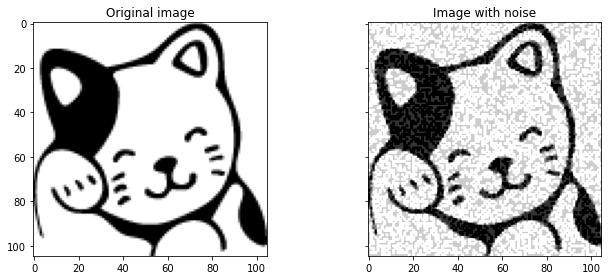

In [17]:
import numpy as np
import sympy as sp
from PIL import Image
from scipy import interpolate
import matplotlib.pyplot as plt
from skimage import data, img_as_float
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error
from skimage import io
from skimage import color

img = color.rgb2gray(io.imread('imagenes_prueba/cat105.png'))

img = img_as_float(img)

rows, cols = img.shape


noise = np.ones_like(img) * 0.2 * (img.max() - img.min())
noise[np.random.random(size=noise.shape) > 0.5] *= -1

img_noise = img + noise

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4),
                         sharex=True, sharey=True)
ax = axes.ravel()


ax[0].imshow(img, cmap=plt.cm.gray, vmin=0, vmax=1)

ax[0].set_title('Original image')

ax[1].imshow(img_noise, cmap=plt.cm.gray, vmin=0, vmax=1)
ax[1].set_title('Image with noise')

plt.tight_layout()
plt.show()

El método a implementar, será utilizando la interpolación bicúbica que viene representada por la siguiente spline

$$
p(x,y) = \sum\limits_{i=0}^3 \sum_{j=0}^3 a_{ij} x^i y^j.
$$
Como se puede observar el problema de interpolación se resume en determinar los 16 coeficientes $a_{ij}$. Ya que la imagen presenta ruido no se puede despejar los coeficientes asumiendo que los valores de las derivadas $f_x$, $f_y$ y $f_{xy}$ son correctas. 

Para determinar los coeficientes se seleccionara secciones solapadas de la imagen de $5\times5 $ pixeles y se determinará una función $p_i$ por cada sección, ejemplificando con una imagen de $9\times 9$  las secciones quedarían de la siguiente manera:


<img src="matriz_seccion.png" width="50%"/>

Se busca la minimización del error cuadrático entre la spline generada $p_i$ y el punto de la imagen, en el caso del ejemplo anterior la función objetivo a minimizar es:

$$(p_1(0,0)-I_{00})^2 + (p_1(0,1)-I_{01})^2 +\dots+(p_1(4,4)-I_{44})^2 + (p_2(4,4)-I_{44})^2+ \dots+(p_4(8,8)-I_{88})^2 $$


Ya que la imagen debe presentar continuidad entre las secciones los pixeles que abarcan más de una deben presentar el mismo valor por lo tanto existen restricciones que se deben cumplir:

$$p_1(0,4) = p_2(0,4)$$
$$p_1(4,4) = p_2(4,4)$$
$$p_1(4,0) = p_3(4,0)$$
$$p_1(4,4) = p_3(4,4)$$
$$\vdots$$

Es decir los valores de los pixeles de solamente las **esquinas** deben ser iguales en todas las secciones que coinciden 

Finalmente al obtener los valores de los coeficientes la nueva imagen será el resultado de la evaluación de todos los pixeles en su spline respectiva

# Preguntas

## 1.Restauración de imagenes

### 1.1 Generar $p_i(x,y)$ (10 pts)

Debe implementar la función `spline_evaluate` que reciba un arreglo con los valores de los coeficientes y el valor de la coordenada $x$ e $y$ del pixel y debe retornar el valor del pixel evaluado en la spline


In [18]:
def spline_evaluate(a,pos):
    '''
    a: (array 16) arreglo de coeficientes
    pos: (tuple) tupla con forma (x,y) que representa la posicion del pixel
    
    return
    value: (float) evaluacion del pixel
      
    '''
    x,y = pos
    a = np.array(a).reshape((4, 4))
    value = 0
    for i in range(0,4):
        for j in range(0,4):
            value += a[i,j]*(x**i)*(y**j) 
    return value


### 1.2 Generar funcion a minimizar (25 pts)

Debe implementar la función `objective_function` que reciba un arreglo con los valores de todos los coeficientes necesarios y la imagen con ruido, y debe retornar el error cuadrático entre el polinomio y el valor del pixel de la imagen.


In [19]:
def objective_function(a,image):
    '''
    a: (array) array con todos los coeficientes 
    image: (array nxn) imagen que presenta ruido en sus datos
    
    return
    error: suma total del error cuadratico entre la spline evaluada y el valor del pixel respectivo
    
    
    '''
    error_total = 0
    cantidad_splines = len(a)/16
    a = np.array(a).reshape(len(a)//16,16)
    n = image.shape[0]
    splines_fila = int(np.sqrt(cantidad_splines))
    vector_filas = np.array([0,1,2,3,4])
    vector_columnas = np.array([0,1,2,3,4])
    spline_evaluada = np.zeros((image.shape[0],image.shape[1]))
    for i in range(0,int(cantidad_splines)):
        if (i%splines_fila == 0) and (i!=0) :
            vector_columnas = np.array([0,1,2,3,4])
            vector_filas = vector_filas + 4
        for i_p in vector_filas:
            for j_p in vector_columnas:
                spline_evaluada[i_p,j_p] = spline_evaluate(a[i],(i_p,j_p))
        vector_columnas = vector_columnas + 4  
    mat_error = image - spline_evaluada
    mat_error = (mat_error)**2
    
    error = np.sum(mat_error)
    
    return error
image_test = np.zeros((13,13))
objective_function(list(range(0,26*26*16)),img_noise)

<ipython-input-18-c30d12f565bc>:15: RuntimeWarning: overflow encountered in long_scalars
  value += a[i,j]*(x**i)*(y**j)


1.6319494535052553e+22

### 1.3 Generar Restricciones (25 pts)

Se debe implementar la función `create_constraints` que reciba la imagen y retorne una lista de diccionarios con las restricciones del problema. El diccionario debe tener la siguiente estructura:

`{"type: "eq", "fun": funcion_con_restriccion}`



In [20]:
def create_constraints(image):
    '''
    image: (array nxn) imagen que presenta ruido en sus datos
    
    return
    constraints: (list) lista de restricciones  
    '''
    error_total = 0
    cantidad_splines = ((int(image.shape[0])-1)/4)**2
    n = int(image.shape[0])
    splines_fila = int(np.sqrt(cantidad_splines))
    vector_filas = np.array([0,1,2,3,4])
    vector_columnas = np.array([0,1,2,3,4])
    orden_spline = np.zeros((splines_fila,splines_fila))
    print(orden_spline.shape)
    constraints = []
    spline_evaluada = np.zeros((image.shape[0],image.shape[1]))
    num = 0
    for i in range(0,splines_fila):
        for j in range(0,splines_fila):
            orden_spline[i,j] = num
            num +=1
    initial_row = np.array((0,4))
    for i in range(0,splines_fila):
        for j in range(0,splines_fila):
            spline = orden_spline[i,j]
            if (spline%splines_fila ==0) and (spline !=0):
                initial_row = initial_row + 4
            if (j-1 >=0) and (j-1 < splines_fila):
                spline_j = orden_spline[i,j-1]
                aux = {}
                aux["type"] = "eq"
                aux["fun"]  = lambda coeficientes,spl,spline : spline_evaluate(coeficientes[spline_j],(initial_row[0],spline*4))
                aux["type"] = "eq"
                aux["fun"]  = lambda coeficientes,spl,spline : spline_evaluate(coeficientes[spline_j],(initial_row[1],spline*4))
                aux["type"] = "eq"
                aux["fun"]  = lambda coeficientes,spl,spline : spline_evaluate(coeficientes[spline_j],(initial_row[0],(spline+1)*4))
                aux["type"] = "eq"
                aux["fun"]  = lambda coeficientes,spl,spline : spline_evaluate(coeficientes[spline_j],(initial_row[1],(spline+1)*4))
                constraints.append(aux)
            if (j+1 >=0) and (j+1 < splines_fila):
                spline_j = orden_spline[i,j+1]
                aux = {}
                aux["type"] = "eq"
                aux["fun"]  = lambda coeficientes,spl,spline : spline_evaluate(coeficientes[spline_j],(initial_row[0],spline*4))
                aux["type"] = "eq"
                aux["fun"]  = lambda coeficientes,spl,spline : spline_evaluate(coeficientes[spline_j],(initial_row[1],spline*4))
                aux["type"] = "eq"
                aux["fun"]  = lambda coeficientes,spl,spline : spline_evaluate(coeficientes[spline_j],(initial_row[0],(spline+1)*4))
                aux["type"] = "eq"
                aux["fun"]  = lambda coeficientes,spl,spline : spline_evaluate(coeficientes[spline_j],(initial_row[1],(spline+1)*4))
                constraints.append(aux)
            if (i+1 < splines_fila):
                spline_j = orden_spline[i+1,j]
                aux = {}
                aux["type"] = "eq"
                aux["fun"]  = lambda coeficientes,spl,spline : spline_evaluate(coeficientes[spline_j],(initial_row[0],spline*4))
                aux["type"] = "eq"
                aux["fun"]  = lambda coeficientes,spl,spline : spline_evaluate(coeficientes[spline_j],(initial_row[1],spline*4))
                aux["type"] = "eq"
                aux["fun"]  = lambda coeficientes,spl,spline : spline_evaluate(coeficientes[spline_j],(initial_row[0],(spline+1)*4))
                aux["type"] = "eq"
                aux["fun"]  = lambda coeficientes,spl,spline : spline_evaluate(coeficientes[spline_j],(initial_row[1],(spline+1)*4))
                constraints.append(aux)
            
    return constraints
create_constraints(img_noise)

(26, 26)


[{'type': 'eq',
  'fun': <function __main__.create_constraints.<locals>.<lambda>(coeficientes, spl, spline)>},
 {'type': 'eq',
  'fun': <function __main__.create_constraints.<locals>.<lambda>(coeficientes, spl, spline)>},
 {'type': 'eq',
  'fun': <function __main__.create_constraints.<locals>.<lambda>(coeficientes, spl, spline)>},
 {'type': 'eq',
  'fun': <function __main__.create_constraints.<locals>.<lambda>(coeficientes, spl, spline)>},
 {'type': 'eq',
  'fun': <function __main__.create_constraints.<locals>.<lambda>(coeficientes, spl, spline)>},
 {'type': 'eq',
  'fun': <function __main__.create_constraints.<locals>.<lambda>(coeficientes, spl, spline)>},
 {'type': 'eq',
  'fun': <function __main__.create_constraints.<locals>.<lambda>(coeficientes, spl, spline)>},
 {'type': 'eq',
  'fun': <function __main__.create_constraints.<locals>.<lambda>(coeficientes, spl, spline)>},
 {'type': 'eq',
  'fun': <function __main__.create_constraints.<locals>.<lambda>(coeficientes, spl, spline)>},
 

### 1.3 Generar nueva imagen (30 pts)
Se debe implementar la función `clean_image` que reciba un arreglo con una imagen en escala de grises y si es que se consideran las restricciones de continuidad. Debe retornar una nueva imagen con el ruido minimizado. 
Para realizar la minimización, debe utilizarse la función [minimize de la libreria de scipy](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html)


In [21]:
def clean_image(image,constraints):
    '''
    image: (array nxn) imagen con ruido
    constraints: (bool) true si es que se consideran las restricciones
    
    return
    new_iamge: (array nxn) imagen restaurada
    '''
    return new_image

## 2. Evaluar error (5 pts)

Implemente la función `error_restore` la cual debe obtener el error de la imagen obtenida comparándola con una de referencia. El error debe ser calculado utilizando el índice SSIM (Structural similarity)

In [22]:
def error_restore(original,new):
    """
    Parameters
    ----------
    image:	(nxn array) imagen original limpia
    new:	(nxn array) imagen restaurada


    Returns
    -------
    error:	(float) diferencia entre imagenes (1-ssim) 

    """
    return error

**Pregunta: ¿Como afecta el uso de restricciones en el error?** (5 pts)

# Consideraciones

* Se trabajará con imágenes cuadradas en escala de grises
* Las imágenes tendrán una dimensión adecuada para que no sobren o falten pixeles para la agrupación de $5\times5$
* Para los casos de los pixeles que no tienen restricción pero pueden ser evaluados por distintas splines considere el valor de la spline de la izquierda o superior
